In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import norm,skew
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#浮動小数点数の出力を小数点以下3桁に制限する
pd.set_option('display.float_format',lambda x:'{:.3f}'.format(x))

In [4]:
#ドライブのマウント
from google.colab import drive
drive.mount('/content/drive')
INPUT_PATH_1 = "/content/drive/My Drive/HousePrices/input/"
INPUT_PATH_2 = "/content/drive/My Drive/HousePrices/features/"

#train.csvをドライブをマウントした状態で読み込む
df_train = pd.read_csv(INPUT_PATH_1 + 'train.csv')
df_test = pd.read_csv(INPUT_PATH_1 + 'test.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#サンプル数、特徴量のチェック
print('before droping Id:{}'.format(df_train.shape))
print('before droping Id:{}'.format(df_test.shape))

#Idカラムだけのデータフレームを別に作成
train_ID = df_train['Id']
test_ID = df_test['Id']

#Id列は予測処理に不要なので削除する。
df_train.drop('Id',axis=1,inplace=True)
df_test.drop('Id',axis=1,inplace=True)

#サンプル数、特徴量を再チェック
print('after droping Id:{}'.format(df_train.shape))
print('after droping Id:{}'.format(df_test.shape))

before droping Id:(1460, 81)
before droping Id:(1459, 80)
after droping Id:(1460, 80)
after droping Id:(1459, 79)


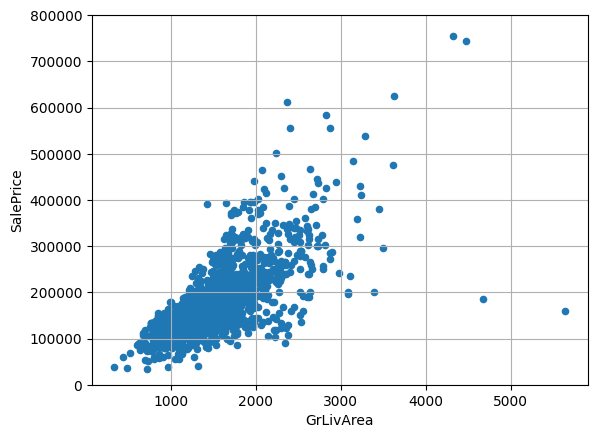

In [6]:
#GrLivArea＝リビングの広さとSalePriceの関係をplot.scatter（）散布図でみる。
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'],df_train[var]],axis=1)
data.plot.scatter(x=var,y='SalePrice',ylim=(0,800000));
plt.grid(True)

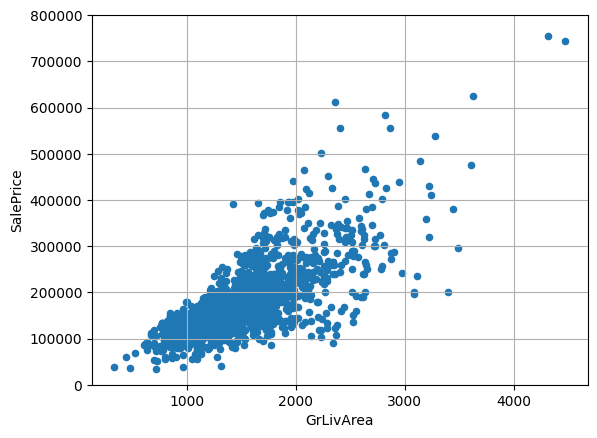

In [7]:
df_train =df_train.drop(df_train[(df_train['GrLivArea']>4000)&(df_train['SalePrice']<200000)].index)

var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'],df_train[var]],axis=1)
data.plot.scatter(x=var,y='SalePrice',ylim=(0,800000));
plt.grid(True)

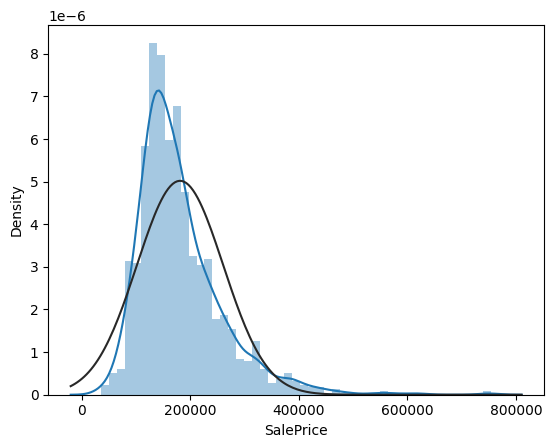

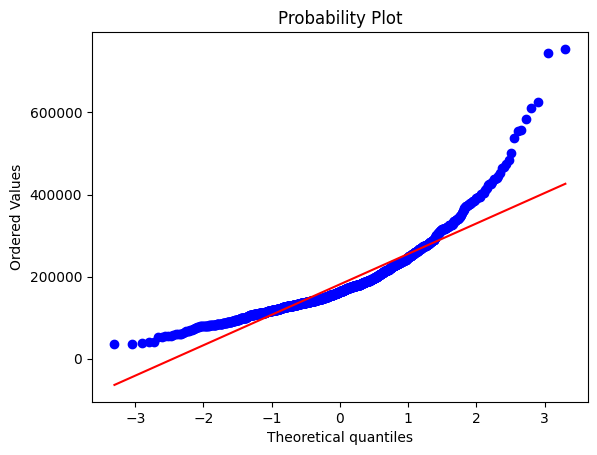

In [8]:
#SalePriceについてヒストグラムと正規分布図を表示
sns.distplot(df_train['SalePrice'],fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'],plot=plt)

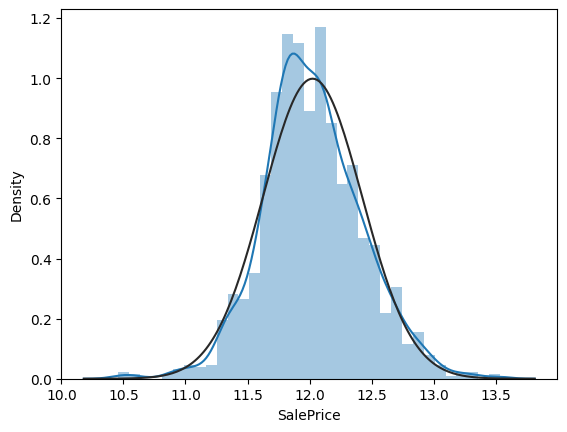

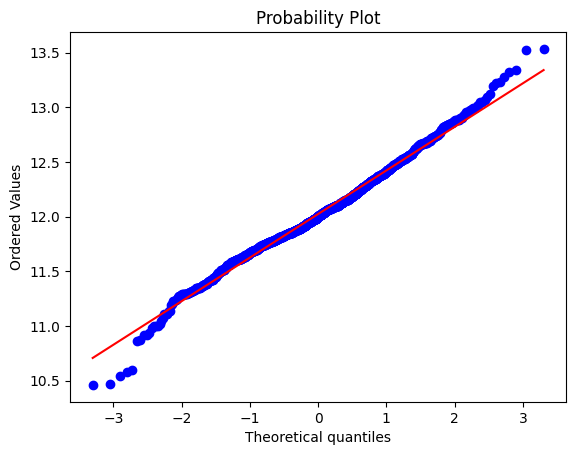

In [9]:
#対数変換した上でヒストグラムと分布図を表示
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

In [10]:
#訓練データとテストデータを同じデータフレームに連結してみましょう。
ntrain = df_train.shape[0]
ntest = df_train.shape[0]
y_train = df_train.SalePrice.values
all_data = pd.concat((df_train,df_test)).reset_index(drop=True)
all_data.drop(['SalePrice'],axis=1,inplace=True)
print('all_data size:{}'.format(all_data.shape))

all_data size:(2917, 79)


In [11]:
all_data_na = (all_data.isnull().sum()/len(all_data))*100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio':all_data_na})
missing_data

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageFinish,5.450806
GarageQual,5.450806
GarageCond,5.450806
GarageYrBlt,5.450806


ValueError: ignored

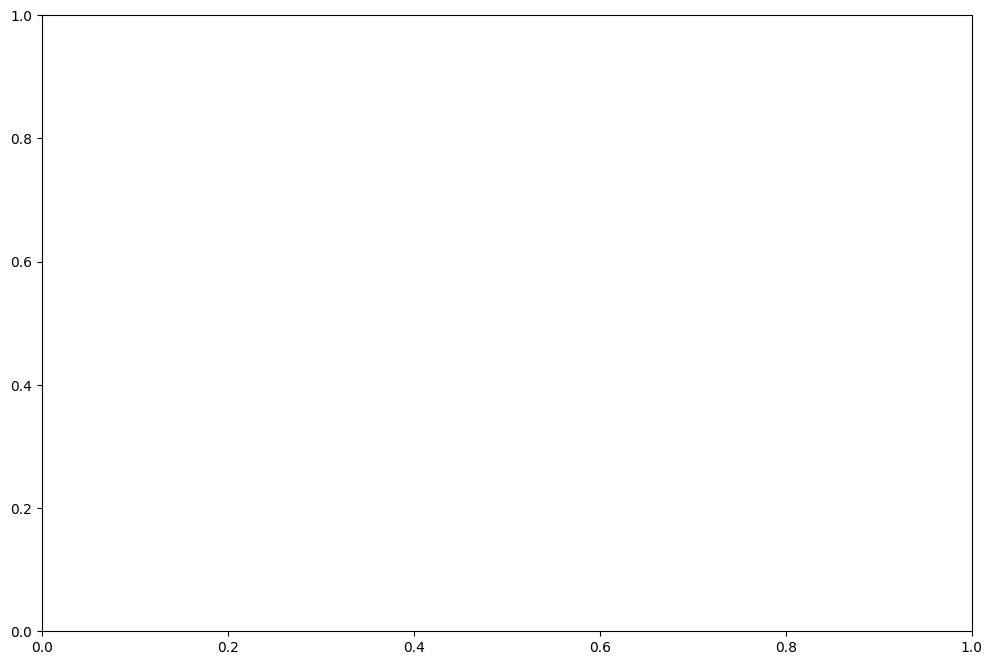

In [12]:
f,ax = plt.subplots(figsize=(12,8))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index,y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

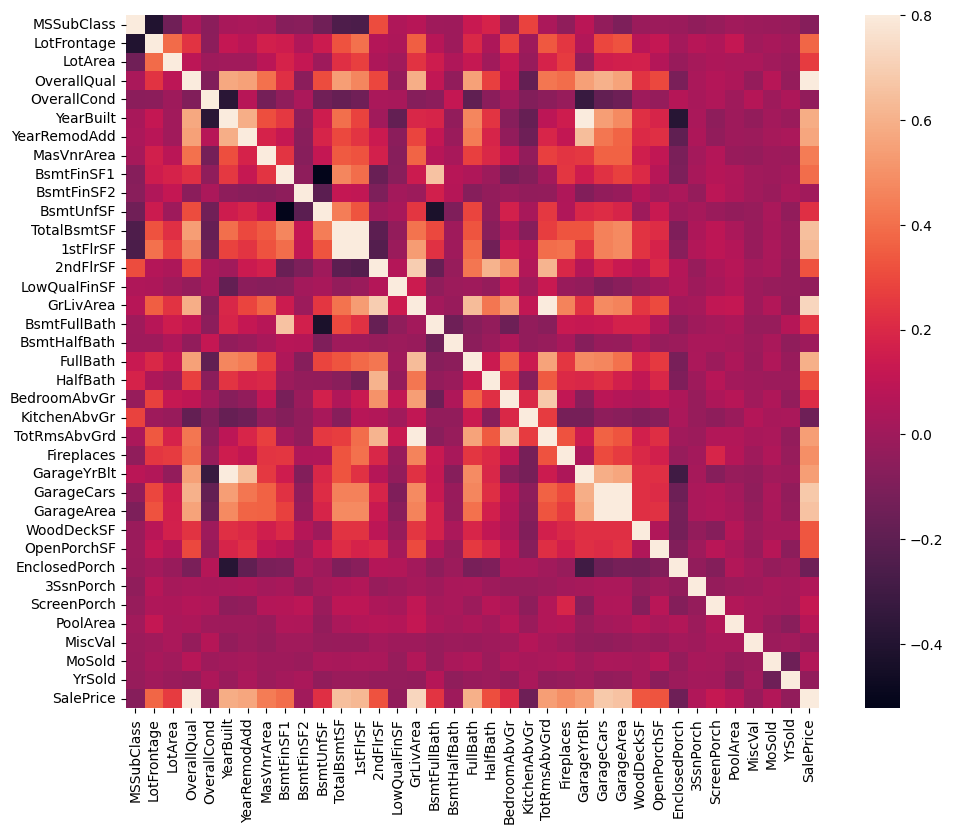

In [13]:
#ヒートマップでみる
corrmat = df_train.corr()
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [14]:
#欠損値の補完
#PoolQC : 「プールなし」。欠損値の割合が大きい（99％）ので、一般にプールがない家が多い。
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')

#MiscFeature : 「他のカテゴリーに含まれない雑多な機能」NAは "misc feature "なし
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

#Alley:「路地」 NAは路地へのアクセスなし
all_data["Alley"] = all_data["Alley"].fillna("None")

#Fence :「フェンス」 NAはフェンスがない
all_data["Fence"] = all_data["Fence"].fillna("None")

#FireplaceQu : 「暖炉」NAは "暖炉なし "を意味する。
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

#LotFrontage :「敷地に接続する道路の直線距離」家の敷地に接続する各ストリートの面積は、近隣の他の家と類似している可能性が高いため、近隣のLotFrontageの中央値で欠損値を埋める。
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x:x.fillna(x.median()))

#GarageType、GarageFinish、GarageQual、GarageCond：欠損データをNoneに置き換える。
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

#GarageYrBlt、GarageArea、GarageCars：欠損データを0に置き換える（ガレージなし＝車庫に車がないため）。
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

#BsmtFinSF1、BsmtFinSF2、BsmtUnfSF、TotalBsmtSF、BsmtFullBath、BsmtHalfBath ：欠損値は地下室がないためゼロと思われる。よって０を埋める。
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

#BsmtQual、BsmtCond、BsmtExposure、BsmtFinType1、BsmtFinType2 ：欠損値は地下室がないためゼロと思われる。よって０を埋める。
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

#MasVnrArea,MasVnrType。NAは、これらの家屋にベニヤがないことを意味している。面積は0、タイプはNoneを代入
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

#MSZoning :「一般的なゾーニング区分」 'RL'が圧倒的に多い値です。だから、'RL'で埋める。
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

#Utilities は削除
all_data = all_data.drop(['Utilities'], axis=1)

#Functional :「家庭用機能性評価」 Typを入れる。
all_data["Functional"] = all_data["Functional"].fillna("Typ")

#Electrical : ほとんど'SBrkr'であるため、欠損値にはそれを設定。
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

#KitchenQual: Electricalと同様、KitchenQualの欠損値には最も頻度の高い「TA」を設定
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

#Exterior1st,Exterior2nd : 最も頻度の高いもので設定
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

#SaleType : 最も頻度の高いもので設定
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

#MSSubClass : 「ビルディングクラス」　欠損値をNoneに置き換えることができる
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [15]:
all_data_na = (all_data.isnull().sum()/len(all_data))*100
all_data_na = all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [16]:
#MSSubClassはビルディングクラスなので変換
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#OverallCondをカテゴリ変数に変更する
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#販売された年と月も変換
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [17]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond',
        'YrSold', 'MoSold')

for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(all_data[c].values))
    all_data[c] = lbl.transform(list(all_data[c].values))

In [18]:
all_data['TotalSF'] = all_data['TotalBsmtSF']+all_data['1stFlrSF']+all_data['2ndFlrSF']

In [19]:
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index
skewed_feats = all_data[numeric_feats].apply(lambda x:skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew':skewed_feats})
skewness.head(10)

,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [20]:
skewness = skewness[abs(skewness)>0.75]
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

In [21]:
all_data = pd.get_dummies(all_data)

In [23]:
#新しい訓練データとテストデータをセットする
train = all_data[:ntrain]
test = all_data[ntrain:]

In [24]:
#ライブラリのインポート
from sklearn.linear_model import ElasticNet,Lasso,BayesianRidge,LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator,TransformerMixin,RegressorMixin,clone
from sklearn.model_selection import KFold,cross_val_score,train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [25]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [26]:
#LASSO回帰
lasso = make_pipeline(RobustScaler(),Lasso(alpha=0.0005,random_state=1))

In [27]:
#Elastic Net
ENet = make_pipeline(RobustScaler(),ElasticNet(alpha=0.0005,l1_ratio=.9,random_state=3))

In [28]:
# カーネルリッジ回帰
KRR = KernelRidge(alpha=0.6,kernel='polynomial',degree=2,coef0=2.5)

In [29]:
#
GBoost = GradientBoostingRegressor(n_estimators=3000,learning_rate=0.05,max_depth=4,max_features='sqrt',min_samples_leaf=15,min_samples_split=10,loss='huber',random_state=5)

In [30]:
#
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                             learning_rate=0.05, max_depth=3,
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [31]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [32]:
#クロスバリデーションのrmsle誤差を評価することで、これらの基本モデルがデータ上でどのように機能するかを見てみよう。
score = rmsle_cv(lasso)
print('Lasso score:{:.4f}({:.4f})'.format(score.mean(), score.std()))

Lasso score:0.1115(0.0074)


In [33]:
score = rmsle_cv(ENet)
print('ElasticNet score:{:.4f}({:.4f})'.format(score.mean(), score.std()))

ElasticNet score:0.1116(0.0074)


In [34]:
score = rmsle_cv(KRR)
print('Kernel Ridge score:{:.4f}({:.4f})'.format(score.mean(), score.std()))

Kernel Ridge score:0.1153(0.0075)


In [35]:
score = rmsle_cv(GBoost)
print('Gradient Boosting score:{:.4f}({:.4f})'.format(score.mean(), score.std()))

Gradient Boosting score:0.1167(0.0083)


In [35]:
score = rmsle_cv(model_xgb)
print('Xgboost score:{:.4f}({:.4f})'.format(score.mean(), score.std()))

In [35]:
score = rmsle_cv(model_lgb)
print('LGBM score:{:.4f}({:.4f})'.format(score.mean(), score.std()))

In [36]:
#ベースとなるモデルの平均化
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    # 元のモデルのクローンを定義
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        # クローン化したベースモデルの学習
        for model in self.models_:
            model.fit(X, y)

        return self

    #クローン化したモデルの予測を行い、平均化
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [ ]:
#ベースとなるモデルの平均化のスコア
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print('Averaged base models score:{:.4f}({:.4f})'.format(score.mean(), score.std()))

In [ ]:
#平均化モデルのスタッキング
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)


        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [ ]:
#平均化モデルのスタッキングのスコア
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print('Stacking　Averaged base models score:{:.4f}({:.4f})'.format(score.mean(), score.std()))

In [ ]:
#StackedRegressor、XGBoost、LightGBMのアンサンブル
def rmsle(y,y_pred):
    return np.sqrt(mean_squared_error(y,y_pred))

In [ ]:
#最終学習と予測
#StackedRegressor:
stacked_averaged_models.fit(train.values,y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train,stacked_train_pred))

In [ ]:
#XGBoost:
model_xgb.fit(train,y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train,xgb_train_pred))

In [ ]:
#LightGBM:
model_lgb.fit(train,y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train,lgb_train_pred))

In [ ]:
#平均化した場合のTrainデータ全体のRMSE
print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

In [ ]:
#アンサンブル予測
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

In [ ]:
#ファイル提出
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv(OUTPUT_PATH + 'submission3.csv',index=False)